In [119]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout
import matplotlib.pyplot as plt


In [120]:
# Load the data
data = pd.read_csv('../datasets/meta.csv')
data.head()

# Reset index
data.reset_index(drop=True, inplace=True)

# Select numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Fill NaN values in numeric columns with the mean of those columns
data[numeric_data.columns] = data[numeric_data.columns].fillna(numeric_data.mean())

# Display the first few rows of the DataFrame
print(data.head())

# Calculate moving average
ma_day = [5, 10, 20, 50]  # Common short-term and long-term windows
for ma in ma_day:
    column_name = f"MA for {ma} days"
    data[column_name] = data['Close'].rolling(window=ma).mean()

# Calculate Exponential moving average
for ma in ma_day:
    column_name = f"EMA for {ma} days"
    data[column_name] = data['Close'].ewm(span=ma, adjust=False).mean()

# Calculate RSI
def compute_RSI(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

data['RSI_14'] = compute_RSI(data)

# Remove any rows with NaN values
data.dropna(inplace=True)
data.head(500)

         Date   Open   High    Low    Close     Volume
0  2012-05-18  42.05  45.00  38.00  38.2318  573576400
1  2012-05-21  36.53  36.66  33.00  34.0300  168192700
2  2012-05-22  32.61  33.59  30.94  31.0000  101786600
3  2012-05-23  31.37  32.50  31.36  32.0000   73600000
4  2012-05-24  32.95  33.21  31.77  33.0300   50237200


,Date,Open,High,Low,Close,Volume,MA for 5 days,MA for 10 days,MA for 20 days,MA for 50 days,EMA for 5 days,EMA for 10 days,EMA for 20 days,EMA for 50 days,RSI_14
49,2012-07-30,23.995,24.04,23.030,23.15,29285900,26.29800,27.52000,29.237800,29.838636,25.546291,27.046144,28.449746,30.538853,15.733114
50,2012-07-31,23.370,23.37,21.610,21.71,56179400,24.95000,26.88200,28.784750,29.508200,24.267527,26.075936,27.807865,30.192623,14.602446
51,2012-08-01,21.500,21.58,20.840,20.88,44604400,23.25800,26.05900,28.268750,29.245200,23.138351,25.131220,27.148068,29.827422,13.890909
52,2012-08-02,20.770,20.84,19.820,20.04,56374500,21.89700,25.16300,27.697250,29.026000,22.105568,24.205544,26.471110,29.443602,13.172414
53,2012-08-03,20.360,22.16,19.900,21.09,80647000,21.37400,24.39600,27.165250,28.807800,21.767045,23.639081,25.958623,29.116010,22.638623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,2014-07-21,68.810,69.96,68.500,69.40,49431600,67.81096,66.58973,66.626865,64.001716,68.007206,67.283914,66.478537,64.769416,56.251778
545,2014-07-22,69.760,69.77,68.610,69.27,40301800,68.23196,67.24073,66.821865,64.242316,68.428138,67.645020,66.744391,64.945909,53.726471
546,2014-07-23,69.740,71.33,69.610,71.29,77435900,68.95796,67.87273,67.100365,64.471516,69.382092,68.307744,67.177306,65.194697,64.538726
547,2014-07-24,75.960,76.74,74.510,74.98,124006900,70.67198,68.88348,67.477365,64.774516,71.248061,69.520881,67.920420,65.578435,71.536342


In [121]:
feature_columns = [
    'Close',          
    'Low',            
    'High',          
    'Open',           
    'EMA for 5 days', 
    'MA for 5 days',  
    'RSI_14'   
]    

features = data[feature_columns].values

# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 15  # 60-day window
X, y = create_sequences(scaled_data, seq_length)

# Split 80/20 chronologically
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(np.isnan(X_train).any(), np.isnan(y_train).any())
print(np.isinf(X_train).any(), np.isinf(y_train).any())

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

False False
False False
Training samples: 2087, Testing samples: 522
X_train shape: (2087, 15, 7), y_train shape: (2087,)


Epoch 1/100


c:\Users\timoz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0253 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0013 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0011 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.4609e-04 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.2401e-04 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.0586e-04 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.6621e-04 - val_loss: 9.1146e-04 - learning_rate: 5.0000e-04
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.6927e-04 - val_loss: 0.0015 - learning_rate: 5.0000e-04
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.1835e-04 - val_loss: 9.9901e-04 - lear

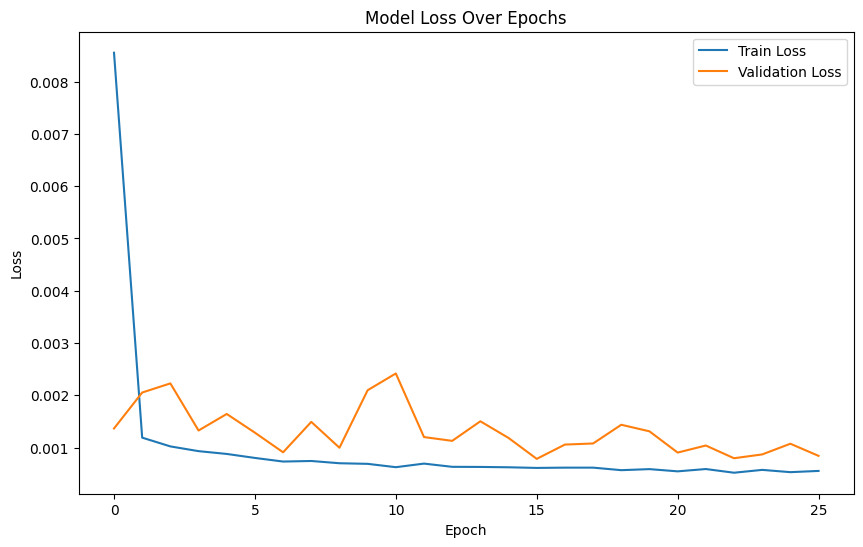

In [122]:
# import adam, earlystopping, and reducelronplateau
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Build GRU-LSTM model
model = Sequential()
model.add(GRU(units=100, return_sequences=True, input_shape=(seq_length, len(feature_columns))))
model.add(Dropout(0.3))  # Increased dropout
model.add(LSTM(units=100))
model.add(Dropout(0.3))
model.add(Dense(units=1))  # L2 regularization could be added here if needed

# Compile with Huber loss and custom optimizer
optimizer = Adam(learning_rate=0.001)  # Lowered learning rate
model.compile(optimizer= optimizer, loss='mse')

# Callbacks for improved training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

# Train with validation
# history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=callbacks, verbose=1)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [123]:
# Predict
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
# Since y is only 'Close', we need to create a dummy array for inverse scaling
y_pred_scaled = np.zeros((len(y_pred), len(feature_columns)))
y_pred_scaled[:, 0] = y_pred[:, 0]  # Place predictions in 'Close' column
y_pred = scaler.inverse_transform(y_pred_scaled)[:, 0]  # Extract 'Close'

y_test_scaled = np.zeros((len(y_test), len(feature_columns)))
y_test_scaled[:, 0] = y_test  # Place actual values in 'Close' column
y_test = scaler.inverse_transform(y_test_scaled)[:, 0]  # Extract 'Close'


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


Performance Metrics
MAE: 9.57
RMSE: 12.70
R^2: 0.98
MAPE: 4.26%


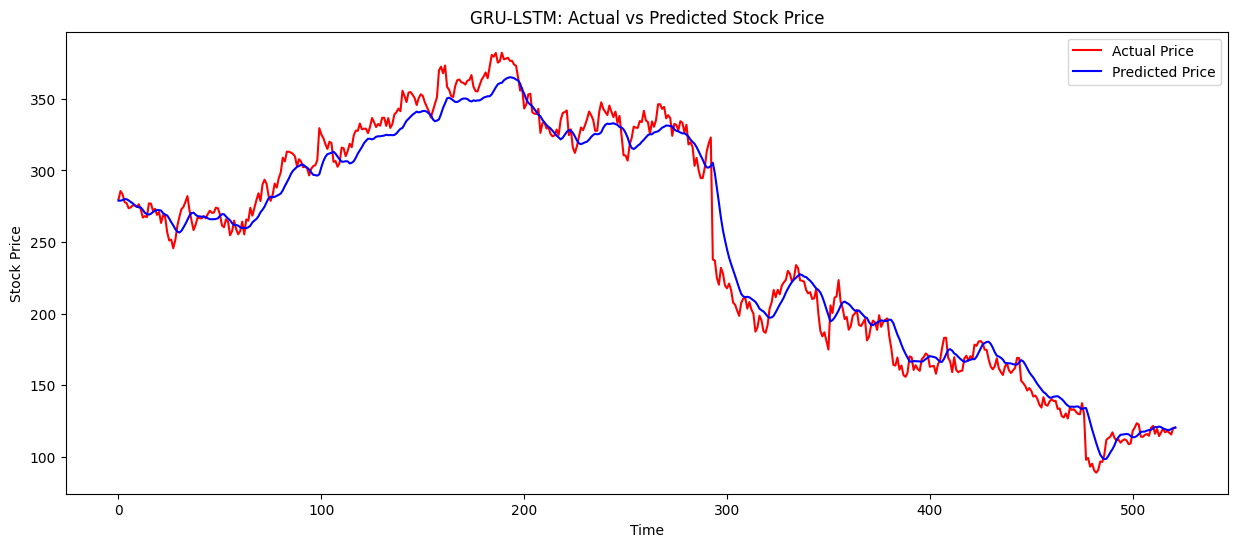

In [124]:
# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("Performance Metrics")
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R^2: {r2:.2f}')
print(f'MAPE: {mape:.2f}%')

# Plot 
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='Actual Price', color='red')
plt.plot(y_pred, label='Predicted Price', color='blue')
plt.title('GRU-LSTM: Actual vs Predicted Stock Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()



In [128]:
# Save model
model.save('gru_lstm_model.keras')